![DSME-logo](./utils/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
Notebook Authors: Lukas Kesper

In this example, we use SARSA to find an optimal policy for the Cliff Walking environment from ["Gymnasium."](https://gymnasium.farama.org/index.html#). An example of the environment is shown below. The goal is to move the elf to the right side without falling off the cliff. The state is the position on the grid, and we can move the elf into the same four directions in each state.

<img src="./utils/cliff_walking.gif" alt="Example of Cliff_Walking" width="500">   

Reference: [Reinforcement Learning: An Introduction, by Richard S. Sutton and Andrew G. Barto](http://incompleteideas.net/book/the-book-2nd.html), 

## Library Imports

In [1]:
%matplotlib inline
import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import custom_envs
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import Video
from IPython.display import display
from screeninfo import get_monitors
from typing import Optional

## Initializations
### Initializing the Agent

Temporal Difference (TD) algorithms are a class of algorithms capable of finding the optimal policy for an environment without needing a model of the environment. In this example, we use the fact, that the action space is independent of the state space. This is a common assumption in reinforcement learning implementations, which allows for a straightforward presentation of the algorithm. However, there are some environments, where this assumption doesn't hold, e.g. the recycling robot from the lecture.

Our `Agent` interacts with the environment to obtain an optimal policy via SARSA. SARSA is an on-policy algorithm, hence, the learned Q-function directly depends on the current policy, which is updated based on the learned Q-function during training. We show the algorithm below.

<img src="./utils/SARSA.png" alt="SARSA algorithm" width="500">   

The training loop can be found in the method `train`. Please note that we call the Q-function `action_value_fn`. Just like in the algorithm above, we use an $\epsilon$-greedy policy via the `epsilon_greedy_policy` method, to ensure exploration. The randomness can be set via the parameter `epsilon`. Additionally, there exists a parameter, `learning_rate`, that is used for updates of the Q-function.

In [2]:
class Agent():
    def __init__(self, env, gamma=1.0, learning_rate=0.05, epsilon=0.1):
        self.env = env
        self.action_value_fn = np.zeros((self.env.observation_space.n, self.env.action_space.n))
        self.learning_rate = learning_rate
        self.gamma = gamma
        self.epsilon = epsilon

    def get_random_action(self):
        random_action = np.random.choice(range(self.env.action_space.n))
        return random_action

    def get_best_action(self, obs):
        best_action = np.random.choice(np.flatnonzero(np.isclose(self.action_value_fn[obs], self.action_value_fn[obs].max(),
                                                                 rtol=0.01)))
        return best_action

    def epsilon_greedy_policy(self, obs):
        # returns action, choosing a random action with probability epsilon, or the best action
        # regarding to Q with probability (1 - epsilon)
        randomly = np.random.random() < self.epsilon
        if randomly:
            action = self.get_random_action()
        else:
            action = self.get_best_action(obs)
        return action

    def train(self, num_episodes, debug=False):
        # Reset environment and pick first action
        for i in range(num_episodes+1):
            obs, info = env.reset()  # most values are replaced in first env.step(),
            action = self.epsilon_greedy_policy(obs)
            done = False
            while not done:
                # In this implementation we only use n=1, but we could extend it for n = ... using a numpy array
                # Choose action and perform step
                next_obs, reward, done, truncated, info = env.step(action)
                # TD Update
                next_action = self.epsilon_greedy_policy(next_obs)
                td_target = reward + self.gamma * self.action_value_fn[next_obs][next_action]
                update = (1-self.learning_rate) * self.action_value_fn[obs][action] + self.learning_rate * td_target
                self.action_value_fn[obs][action] = update
                obs = next_obs
                action = next_action
            if i % 1000 == 0:
                self.visualize(i)

### Preparing the Evaluation

For evaluation, we require methods that visualize the Q-function (`visualize`), as well as a method that is used to evaluate the resulting policy (`evaluate`). We add these methods below.

In [3]:
def visualize(self, epoch): 
    q_fn = np.around(self.action_value_fn, decimals=1)
    fig, ax=plt.subplots(figsize=(18,5))
    lines = 4
    rows = 12
    # Define grid positions:
    pos_x_left = 0.2
    pos_x_mid = 0.5
    pos_x_right = 0.8
    pos_y_up = 0.2
    pos_y_mid = 0.5
    pos_y_down = 0.8
    grid_size = {'x': lines, 'y': rows}
    def gridcreator(pos_x, pos_y):
        grid = []
        for i in range(grid_size['x']):
            for j in range(grid_size['y']):
                x = pos_x + j
                y = pos_y + i
                grid.append((x, y))
        return grid
    top = q_fn[:,0].reshape((lines,rows))
    top_value_positions = gridcreator(pos_x_mid, pos_y_up)
    right = q_fn[:,1].reshape((lines,rows))
    right_value_positions = gridcreator(pos_x_right, pos_y_mid)
    bottom = q_fn[:,2].reshape((lines,rows))
    bottom_value_positions = gridcreator(pos_x_mid, pos_y_down)
    left= q_fn[:,3].reshape((lines,rows))
    left_value_positions = gridcreator(pos_x_left, pos_y_mid)
    # Define triangles
    ax.set_ylim(lines, 0)
    anchor_points = np.array([[0,0],[0,1],[.5,.5],[1,0],[1,1]]) # Corner coordinates
    corner_indizes = np.array([[0,1,2], [0,2,3],[2,3,4],[1,2,4]]) # Corner indices
    xy_coordinates = np.zeros((lines * rows * 5,2))
    triangles = np.zeros((lines * rows * 4, 3))
    for i in range(lines):
        for j in range(rows):
            k = i*rows+j
            xy_coordinates[k*5:(k+1)*5,:] = np.c_[anchor_points[:,0]+j, 
                                                  anchor_points[:,1]+i]
            triangles[k*4:(k+1)*4,:] = corner_indizes + k*5
    colours = np.c_[left.flatten(), top.flatten(), 
            right.flatten(), bottom.flatten()].flatten()
    ax.triplot(xy_coordinates[:,0], xy_coordinates[:,1], triangles, 
               **{"color":"k", "lw":1})
    tripcolor = ax.tripcolor(xy_coordinates[:,0], xy_coordinates[:,1], triangles, 
                             facecolors=colours, **{"cmap": "coolwarm"}, vmin=-10, vmax=0.0)
    ax.margins(0)
    ax.set_aspect("equal")
    fig.colorbar(tripcolor)
    # Define text:
    textsize = 7
    for i, (xi,yi) in enumerate(top_value_positions):
        plt.text(xi,yi,round(top.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    for i, (xi,yi) in enumerate(right_value_positions):
        plt.text(xi,yi,round(right.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    for i, (xi,yi) in enumerate(left_value_positions):
        plt.text(xi,yi,round(left.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    for i, (xi,yi) in enumerate(bottom_value_positions):
        plt.text(xi,yi,round(bottom.flatten()[i],2), size=textsize, color="w", 
                 ha='center', va='center')
    ax.axis('off')
    plt.title("Q-Function, Epoch "+str(epoch))
    # add lines for separation
    for i in range(lines+1):
        x = [0, rows]
        y = [i, i]
        plt.plot(x,y, color='black')
    for i in range(rows+1):
        x = [i, i]
        y = [0, lines]
        plt.plot(x,y, color='black')
    plt.show()

def evaluate(self, env, file, num_runs=5):
    frames = []  # collect rgb_image of agent env interaction
    video_created = False
    for _ in range(num_runs):
        done = False
        obs, info = env.reset()
        out = env.render()
        frames.append(out)
        while not done:
            action = self.get_best_action(obs) 
            obs, reward, done, truncated, info = env.step(action)
            out = env.render()
            frames.append(out)              
    # create animation out of saved frames
    if all(frame is not None for frame in frames):
        fig = plt.figure(figsize=(10, 6))
        plt.axis('off')
        img = plt.imshow(frames[0])
        def animate(index):
            img.set_data(frames[index])
            return [img]
        anim = FuncAnimation(fig, animate, frames=len(frames), interval=20)
        plt.close()
        anim.save(file, writer="ffmpeg", fps=5)

setattr(Agent, 'visualize', visualize)
setattr(Agent, 'evaluate', evaluate)

## Training and Evaluation
Now we train the agent with the algorithm we implemented earlier and evaluate its performance.

### Setting up Agent and Environment
We start by setting up the environment, which is part of our custom environments. We create the environment using `Gymnasium`. Then, we set up an Agent for training. Initially, our Q-function only consists of zeros, but changes during training.

In [4]:
env = gym.make('CliffWalking-v1', render_mode=None)
env.reset()
agent = Agent(env, gamma=0.9, learning_rate=0.1, epsilon=0.2)

### Training the Agent

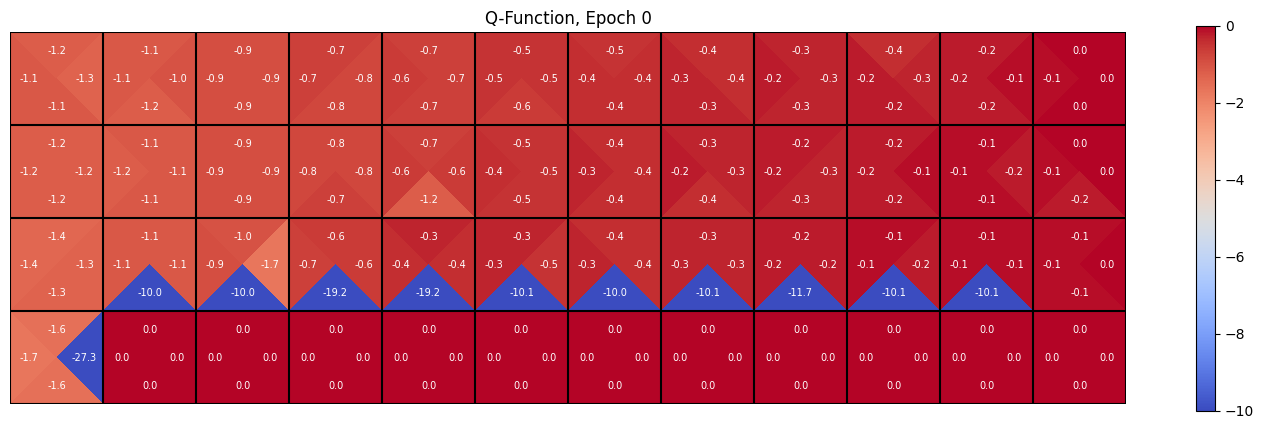

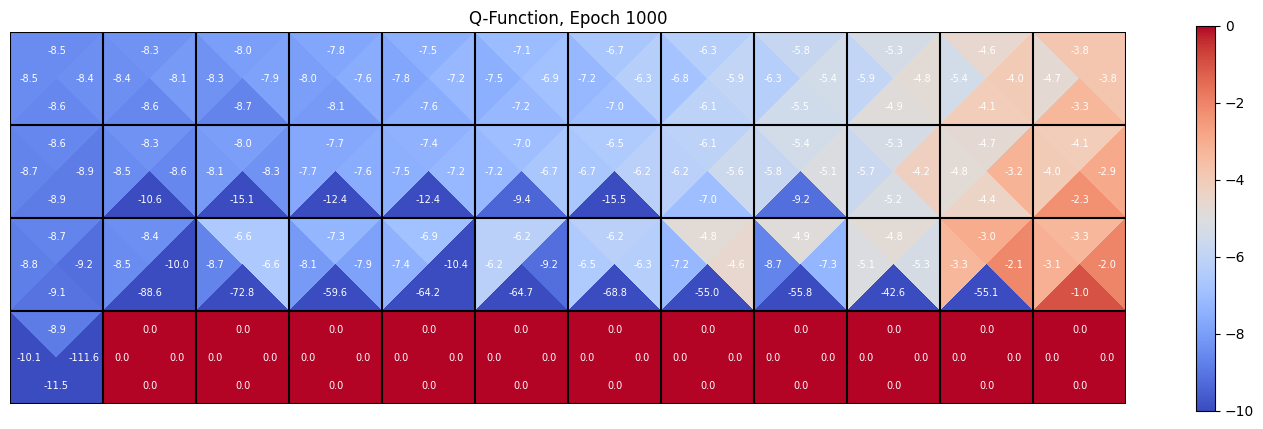

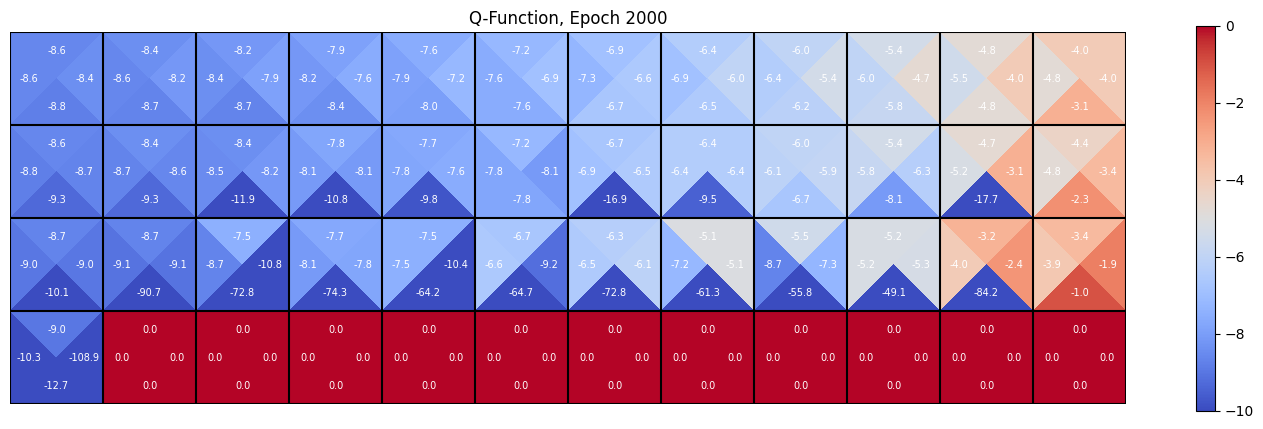

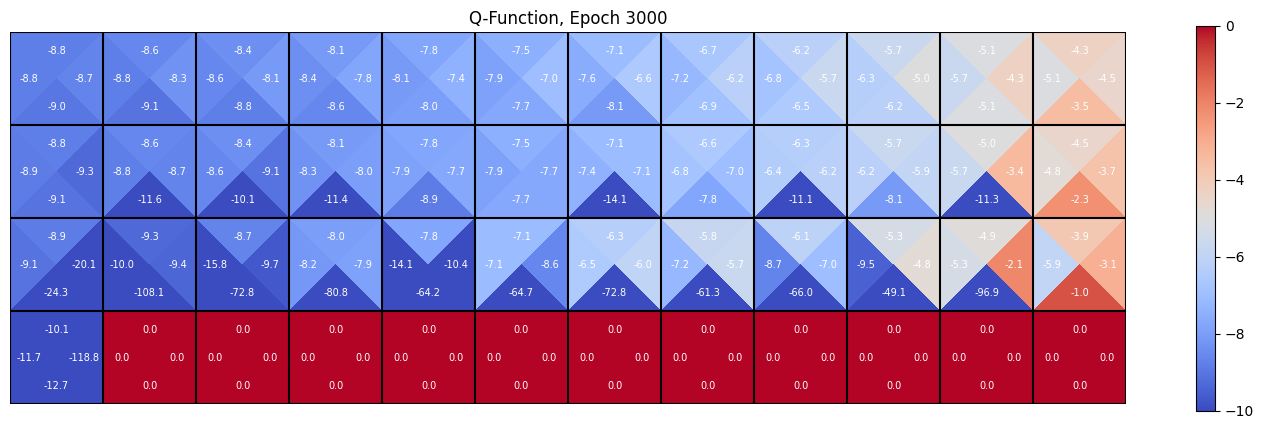

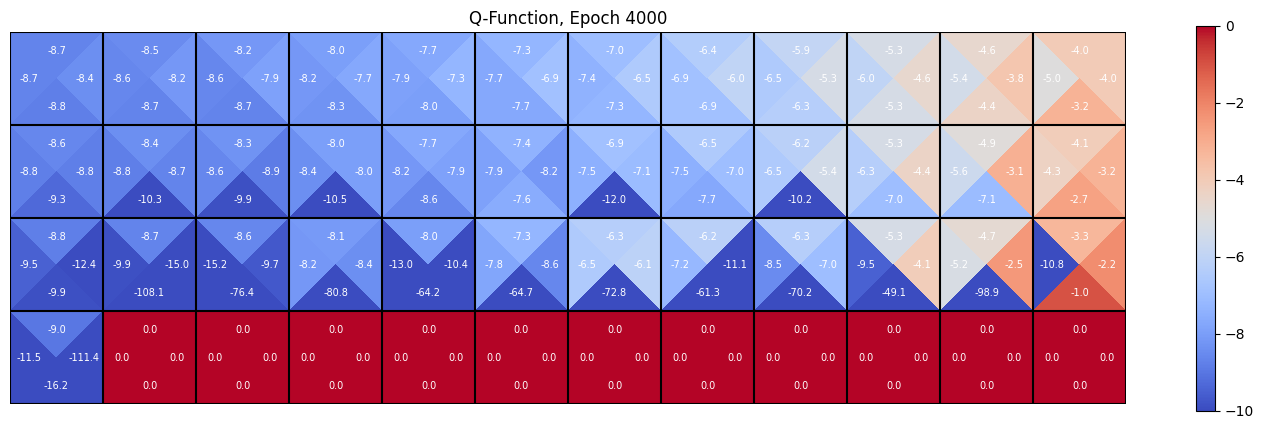

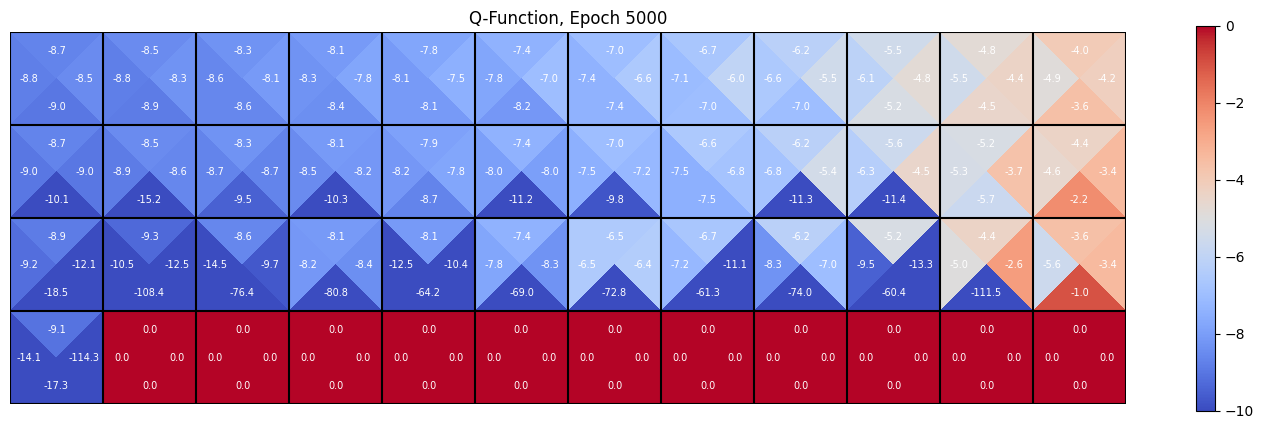

In [5]:
agent.train(num_episodes=5000)

### Evaluation

Above, we can see the evolution of the Q-function during training. The  coloring already indicates what a greedy policy can look like. Below we show a greedy policy in the environment.

In [6]:
env = gym.make('CliffWalking-v1', render_mode='rgb_array')
video = "sarsa.mp4"
agent.evaluate(env, video, num_runs=5)
Video(video, html_attributes="loop autoplay")